<a href="https://colab.research.google.com/github/Ayush-Kaushal/GeoLocator/blob/main/GeoLocator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install opendatasets --upgrade --quiet
!pip install folium --quiet
!pip install haversine --quiet

In [ ]:
import os
import cv2
import torch
import folium
import random
import torchvision
import torch.nn as nn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import opendatasets as od
import haversine as hs
from torchvision.transforms import transforms
from torch.utils.data import random_split
from torch.utils.data import Dataset, DataLoader
from torchvision.utils import make_grid
from torchvision.models import resnet18
from tqdm import tqdm
from skimage import io, transform
from PIL import Image
from haversine import Unit

In [ ]:
dataset_url = 'https://www.kaggle.com/datasets/ayuseless/streetview-image-dataset'
od.download(dataset_url)

In [ ]:
data_dir = "./streetview-image-dataset/Streetview_Image_Dataset/"

In [ ]:
df = pd.read_csv(data_dir + 'coordinates.csv')
df

,latitude,longitude
0,20.824885,-98.499517
1,-3.451752,-54.563937
2,-23.496464,-47.460542
3,-16.548678,-72.852778
4,-35.010870,140.064397
...,...,...
25224,14.564200,121.014760
25225,9.333700,122.863700
25226,14.485150,121.309490
25227,16.412400,120.710720


In [ ]:
df['latitude'] = df['latitude'].div(90.0)
df['longitude'] = df['longitude'].div(180.0)
df.head()

,latitude,longitude
0,0.231388,-0.547220
1,-0.038353,-0.303133
2,-0.261072,-0.263670
3,-0.183874,-0.404738
4,-0.389010,0.778136


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [ ]:
class StreetViewDataset(Dataset):
  def __init__(self, root_dir, csv_file, transform=None):
    self.annotations = df
    self.root_dir = root_dir
    self.transform = transform

  def __len__(self):
    return len(self.annotations)

  def __getitem__(self, index):
    img_path = os.path.join(self.root_dir, f'{index}.png')
    image = io.imread(img_path)
    label = torch.tensor(np.array(self.annotations.iloc[index, 0:]))

    if self.transform:
      image = self.transform(image)

    return image.float(), label.float()

In [ ]:
def stats(dataset):
    mean = np.array([0.,0.,0.])
    stdTemp = np.array([0.,0.,0.])
    std = np.array([0.,0.,0.])

    numSamples = len(dataset)

    for i in range(numSamples):
        im, lab = dataset[i]

        for j in range(3):
            mean[j] += np.mean(np.array(im[j,:,:]))

    mean = (mean/numSamples)
    print(mean)

    for i in range(numSamples):
        im, lab = dataset[i]

        for j in range(3):
            stdTemp[j] += ((im[j,:,:] - mean[j])**2).sum()/(im.shape[1]*im.shape[2])

    std = np.sqrt(stdTemp/numSamples)

    print(std)

    return mean, std


# mean, std = stats(dataset)
mean=[0.51382269, 0.52979455, 0.50922001]
std=[0.21168105, 0.209803, 0.26638921]

In [ ]:
dataset = StreetViewDataset(root_dir=data_dir, csv_file=data_dir+'coordinates.csv', transform=transforms.Compose([transforms.ToPILImage(),
                                                                                                             transforms.Resize(224),
                                                                                                             transforms.ToTensor(),
                                                                                                             transforms.Normalize(mean=[0.51382269, 0.52979455, 0.50922001],
                                                                                                                                  std=[0.21168105, 0.209803, 0.26638921])]))

In [ ]:
len(dataset)

25229

In [ ]:
test_size = 5000
train_size = len(dataset) - test_size
train_ds, test_ds = random_split(dataset, [train_size, test_size])

In [ ]:
batch_size = 64

In [ ]:
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
test_dl = DataLoader(test_ds, batch_size=batch_size, shuffle=True)

images.shape: torch.Size([64, 3, 224, 224])
images.type: <class 'torch.Tensor'>


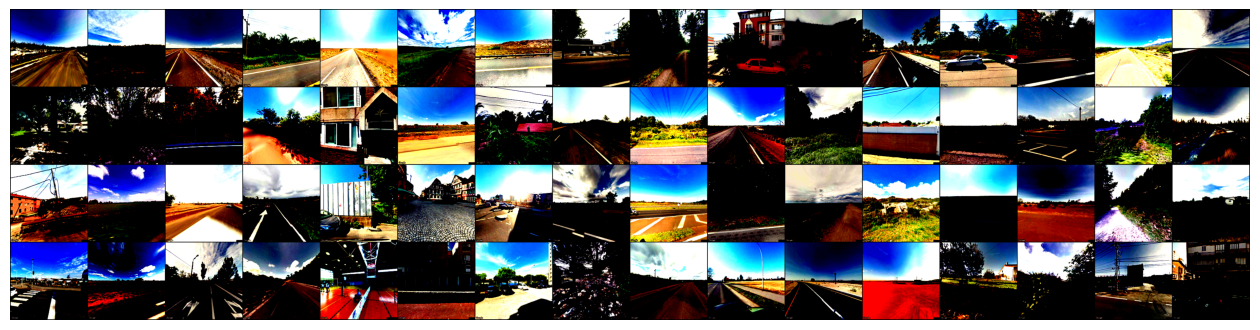

In [ ]:
for images, _ in train_dl:
    print('images.shape:', images.shape)
    print('images.type:', type(images))
    plt.figure(figsize=(16,8))
    plt.axis('off')
    plt.imshow(make_grid(images, nrow=16).permute((1, 2, 0)))
    break

In [ ]:
model = resnet18(pretrained=True)
model.fc = nn.Sequential(
    nn.Linear(512, 512),
    nn.BatchNorm1d(512),
    nn.Dropout(0.3),
    nn.ReLU(),

    nn.Linear(512, 512),
    nn.BatchNorm1d(512),
    nn.Dropout(0.3),
    nn.ReLU(),

    nn.Linear(512, 64),
    nn.BatchNorm1d(64),
    nn.Dropout(0.2),
    nn.ReLU(),

    nn.Linear(64, 2),
    nn.Tanh()
)
model.to(device)

In [ ]:
FILE1 = 'Model_Val'
num_epochs = 25
optimizer = torch.optim.Adam(model.parameters())
criterion = nn.MSELoss()

In [ ]:
class EarlyStopper:
    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = np.inf

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
            torch.save(model.state_dict(), FILE)
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

In [ ]:
early_stopper = EarlyStopper(patience=4, min_delta=2)
torch.cuda.empty_cache()
Train_Loss = []

In [ ]:
for epoch in range(num_epochs):
    # Training
    model.train()
    train_loss = 0.0
    for _, data in enumerate(tqdm(train_dl)):
      x, y = data
      x = x.to(device)
      y = y.to(device)

      pred = model(x)

      loss = criterion(pred, y)
      train_loss += loss.item()
      Train_Loss.append(loss.item())

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()


    # Validating
    val_loss = 0.0
    model.eval()
    with torch.no_grad():
      for _, data in enumerate(tqdm(test_dl)):
        x, y = data
        x = x.to(device)
        y = y.to(device)

        pred = model(x)

        loss = criterion(pred, y)
        val_loss += loss.item()

    print(f"Epoch: {epoch+1}, Train Loss: {train_loss}, Val Loss: {val_loss}")

    if early_stopper.early_stop(val_loss):
        break

In [ ]:
plt.plot(Train_Loss)

In [ ]:
Test_Loss = []

model.eval()
test_loss = 0.0
for _, data in enumerate(tqdm(test_dl)):
  x, y = data
  x = x.to(device)
  y = y.to(device)

  pred = model(x)

  loss = criterion(pred, y)
  test_loss += loss.item()
  Test_Loss.append(loss.item())


print(f"Loss: {test_loss}")

In [ ]:
plt.plot(Test_Loss)

1574


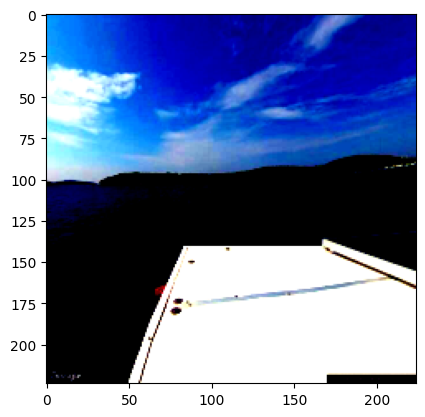

In [ ]:
idx = random.randrange(0,test_size - 1)
print(idx)
img, lab = test_ds[idx]
plt.imshow(img.permute(1, 2, 0))

img = img[np.newaxis, :]
img = img.to(device)
lab = lab.to(device)
pred = model(img)

In [ ]:
pred_loc = (pred[0,0].item()*90, pred[0,1].item()*180)
real_loc = (lab[0].item()*90, lab[1].item()*180)

print(f'Pred: {pred_loc}')
print(f'Actual: {real_loc}')

result=hs.haversine(pred_loc, real_loc, unit=Unit.KILOMETERS)
print(f"The distance calculated is: {result} km")

Pred: (40.85875779390335, 13.306288719177246)
Actual: (43.52372020483017, 15.966849625110626)
The distance calculated is: 368.5412561977148 km


In [ ]:
m = folium.Map()
folium.Marker(real_loc, popup='Actual', icon=folium.Icon(color='green')).add_to(m)
folium.Marker(pred_loc, popup='Predicted', icon=folium.Icon(color='red')).add_to(m)
m.fit_bounds(m.get_bounds(), padding=(200, 200))
m

In [ ]:
def test_random():
    model.eval()
    idx = random.randrange(0,test_size - 1)
    img, lab = test_ds[idx]
    #plt.imshow(img.permute(1, 2, 0))

    img = img[np.newaxis, :]
    img = img.to(device)
    lab = lab.to(device)

    pred_train = model(img)

    pred_loc_train = (pred_train[0,0].item()*90, pred_train[0,1].item()*180)
    real_loc = (lab[0].item()*90, lab[1].item()*180)

    print(f'Actual: {real_loc}')

    print()

    print(f'Pred Train: {pred_loc_train}')
    d1 = hs.haversine(pred_loc_train, real_loc, unit=Unit.KILOMETERS)
    print(f"The distance calculated is: {d1} km")

    m = folium.Map()
    folium.Marker(real_loc, popup='Actual', icon=folium.Icon(color='green')).add_to(m)
    folium.Marker(pred_loc_train, popup='Predicted Train', icon=folium.Icon(color='red')).add_to(m)
    m.fit_bounds(m.get_bounds(), padding=(200, 200))

    return m

In [ ]:
map_rand = test_random()
map

In [ ]:
FILE2 = 'Train_Model'
torch.save(model.state_dict(), FILE2)

# Loading Val Model

In [ ]:
model_val.load_state_dict(torch.load(FILE1))

<All keys matched successfully>

In [ ]:
def test_models():
    model.eval()
    idx = random.randrange(0,test_size - 1)
    img, lab = test_ds[idx]


    img = img[np.newaxis, :]
    img = img.to(device)
    lab = lab.to(device)

    pred_train = model(img)
    pred_val = model_val(img)

    pred_loc_train = (pred_train[0,0].item()*90, pred_train[0,1].item()*180)
    pred_loc_val = (pred_val[0,0].item()*90, pred_val[0,1].item()*180)
    real_loc = (lab[0].item()*90, lab[1].item()*180)

    print(f'Actual: {real_loc}')

    print()

    print(f'Pred Train: {pred_loc_train}')
    d1 = hs.haversine(pred_loc_train, real_loc, unit=Unit.KILOMETERS)
    print(f"The distance calculated is: {d1} km")

    print()

    print(f'Pred Val: {pred_loc_val}')
    d2 = hs.haversine(pred_loc_val, real_loc, unit=Unit.KILOMETERS)
    print(f"The distance calculated is: {d2} km")

    m = folium.Map()
    folium.Marker(real_loc, popup='Actual', icon=folium.Icon(color='green')).add_to(m)
    folium.Marker(pred_loc_train, popup='Predicted Train', icon=folium.Icon(color='red')).add_to(m)
    folium.Marker(pred_loc_val, popup='Predicted Val', icon=folium.Icon(color='orange')).add_to(m)
    m.fit_bounds(m.get_bounds(), padding=(200, 200))

    return m

In [ ]:
map = test_models()
map

Actual: (40.215089321136475, -3.334989957511425)

Pred Train: (47.580885887145996, 33.754876255989075)
The distance calculated is: 3050.58712885624 km

Pred Val: (-5.624748878180981, -60.55740773677826)
The distance calculated is: 7742.127819458349 km
